In [10]:
import pandas as pd

data = pd.read_parquet('announcement/processed_LLM_data_train_1_10_30_32k.parquet')
data

,symbol,time,content,log_r
0,600031.SH,2018-10-10 09:00:00,现在是2018-10-10 09:00:00+08:00\n时间：2018-10-09 17...,-0.028921
1,600031.SH,2018-10-24 09:00:00,现在是2018-10-24 09:00:00+08:00\n时间：2018-10-09 17...,-0.023473
2,600031.SH,2018-12-07 09:00:00,现在是2018-12-07 09:00:00+08:00\n时间：2018-12-06 18...,-0.003693
3,600031.SH,2018-12-24 09:00:00,现在是2018-12-24 09:00:00+08:00\n时间：2018-12-06 18...,-0.008250
4,600031.SH,2018-12-24 09:00:00,现在是2018-12-24 09:00:00+08:00\n时间：2018-12-06 18...,-0.008250
...,...,...,...,...
6323,601668.SH,2023-03-31 09:00:00,现在是2023-03-31 09:00:00+08:00\n时间：2023-03-12 15...,0.015558
6324,601668.SH,2023-03-31 09:00:00,现在是2023-03-31 09:00:00+08:00\n时间：2023-03-12 15...,0.015558
6325,601668.SH,2023-03-31 09:00:00,现在是2023-03-31 09:00:00+08:00\n时间：2023-03-12 15...,0.015558
6326,601668.SH,2023-03-31 09:00:00,现在是2023-03-31 09:00:00+08:00\n时间：2023-03-12 15...,0.015558


In [11]:
print(data['log_r'].min())
print(data['log_r'].max())

-0.1483098449219742
0.19195387493001637


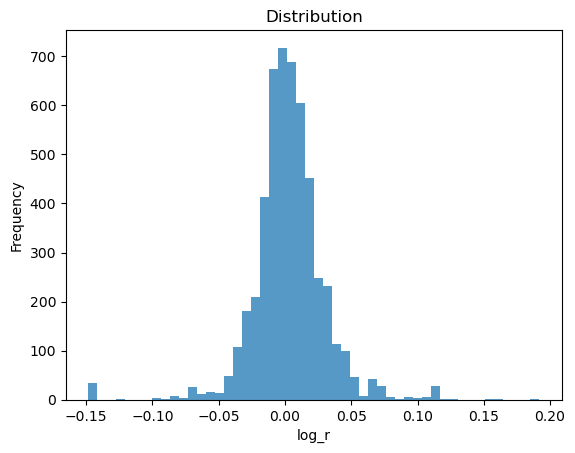

sigma: 0.028, mean: 0.003, variance: 0.001


In [12]:
import matplotlib.pyplot as plt

plt.hist(data['log_r'], bins=50, alpha=0.75)
plt.title('Distribution')
plt.xlabel('log_r')
plt.ylabel('Frequency')
plt.show()

sigma = round(data['log_r'].std(), 3)
mean = round(data['log_r'].mean(), 3)
variance = round(data['log_r'].var(), 3)

print(f'sigma: {sigma}, mean: {mean}, variance: {variance}')

In [13]:
data['label'] = pd.qcut(data['log_r'], 5, labels=False)
print(data[['log_r', 'label']].head())

      log_r  label
0 -0.028921      0
1 -0.023473      0
2 -0.003693      1
3 -0.008250      1
4 -0.008250      1


In [14]:
# print(data['content'][0])

In [15]:
import pandas as pd
import json
from tqdm import tqdm
from transformers import AutoTokenizer
from concurrent.futures import ThreadPoolExecutor


def process_row(row):
    try:
        stock_mapping = {
            "600031.SH": "三一重工",
            "600036.SH": "招商银行",
            "600050.SH": "中国联通",
            "600104.SH": "上汽集团",
            "600346.SH": "恒力石化",
            "600570.SH": "恒生电子",
            "600887.SH": "伊利股份",
            "601390.SH": "中国中铁",
            "603160.SH": "汇项科技",
            "601668.SH": "中国建筑"
        }
        stock = stock_mapping[row['symbol']]
        prompt = f"请根据以下新闻文本，预测{stock}股票的对数收益率属于以下哪一类别 (极度负面/负面/中性/正面/极度正面)"
        label_mapping = {0: "极度负面", 1: "负面", 2: "中性", 3: "正面", 4: "极度正面"}
        label = label_mapping[row['label']]

        # def calculate_token_length(text):
        #     model_name = "/home/zhangmin/.cache/modelscope/hub/qwen/Qwen-7B-Chat"
        #     tokenizer = AutoTokenizer.from_pretrained(model_name,  trust_remote_code=True)
        #     tokens = tokenizer.encode(text, truncation=True)
        #     return len(tokens)

        # token = calculate_token_length(row['content'])

        return {
            "prompt": prompt,
            "content": row['content'],
            "label": label,
            # "token": token
        }
    except Exception as e:
        print(f"Error processing row: {e}")
        return None


def generate_dataset(df, max_samples=32):
    df_subset = df.head(max_samples)
    results = []
    with ThreadPoolExecutor(max_workers=50) as executor:
        futures = [executor.submit(process_row, row) for _, row in df_subset.iterrows()]
        for future in tqdm(futures, total=len(futures), desc="Processing rows"):
            result = future.result()
            if result:
                results.append(result)

    return results


# processed_data = [process_row(row) for _, row in tqdm(data.iterrows(), total=data.shape[0]) if process_row(row) is not None]
processed_data = generate_dataset(data, max_samples=10000)
output_file_path = 'ft_data_32k.json'
with open(output_file_path, 'w', encoding='utf-8') as f:
    json.dump(processed_data, f, ensure_ascii=False, indent=2)

Processing rows: 100%|██████████| 5087/5087 [00:00<00:00, 583775.87it/s]


In [16]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(processed_data, test_size=0.1, random_state=42)

train_file_path = 'ft_data_32k/train.json'
test_file_path = 'ft_data_32k/test.json'

with open(train_file_path, 'w', encoding='utf-8') as f:
    json.dump(train_data, f, ensure_ascii=False, indent=2)

with open(test_file_path, 'w', encoding='utf-8') as f:
    json.dump(test_data, f, ensure_ascii=False, indent=2)

In [17]:
# import json

# with open('ft_data.json', 'r', encoding='utf-8') as f:
#     data = json.load(f)

# count = sum(1 for d in data if d['token'] >= 8192)
# print(f"The number of data with token length greater than 8192 is: {count}")

In [18]:
# import json
# from sklearn.model_selection import train_test_split

# with open('ft_data.json', 'r', encoding='utf-8') as f:
#     data = json.load(f)
# filtered_data = [d for d in data if d['token'] < 8192]
# train_data, test_data = train_test_split(filtered_data, test_size=0.2, random_state=42)
# with open('ft_data/train.json', 'w', encoding='utf-8') as f:
#     json.dump(train_data, f, ensure_ascii=False, indent=4)
# with open('ft_data/test.json', 'w', encoding='utf-8') as f:
#     json.dump(test_data, f, ensure_ascii=False, indent=4)